In [1]:
# Copyright (c) 2022 rxn4chemistry 
# - Mark Martori Lopez
import glob
import cv2
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

/lustre/BIF/nobackup/silva045/miniforge3/envs/ochemR/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


##### Read Training Data Set

In [2]:
images = []
def imagesIds(path):
    for img in glob.glob(path+"*.png"):
        images.append(img) 
    return images
def getDF(path):
    """
    Returns dataframe format of training images.
    """
    listImgs = imagesIds(path)
    df = pd.DataFrame(listImgs, index=None)
    return df

df = getDF("../../images/train/")
df.iloc[2][0]

'../../images/train/Final_reaction_Epoch1_it_533.png'

In [3]:
class Arrow(Dataset):
    def __init__(self,data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        path  = os.path.join(self.directory, self.data.iloc[idx][0]) # import
        image = cv2.imread(path) #, cv2.COLOR_BGR2RGB)
            
        # augmentations
        if self.transform is not None:
            image = self.transform(image = image)['image']
        return image
augs = A.Compose([A.Resize(height = 512, width  = 512),A.Normalize(mean = (0, 0, 0),std  = (1, 1, 1)), ToTensorV2()])

##### Examine a sample batch

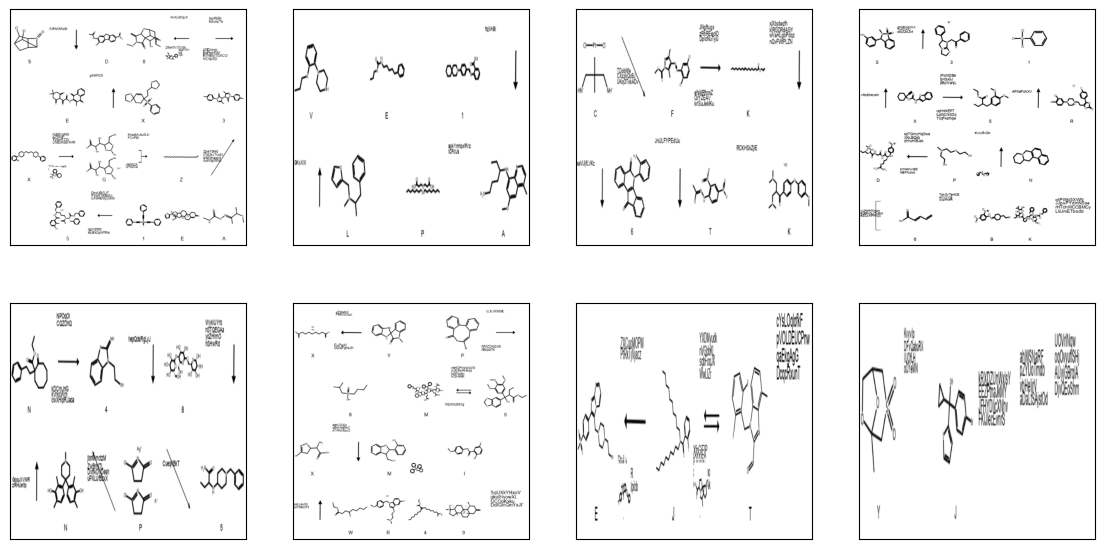

In [4]:
# dataset
image_dataset = Arrow(data      = df, directory = '', transform = augs)

# data loader
image_loader = DataLoader(image_dataset, batch_size  = 32, shuffle     = False)
                          
# display images
for batch_idx, inputs in enumerate(image_loader):
    fig = plt.figure(figsize = (14, 7))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
    break

##### Compute MEAN and STD

In [5]:
# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])
# loop through images
c = 0
for inputs in tqdm(image_loader):
    try:
        psum    += inputs.sum(axis        = [0, 2, 3])
        psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])
    except:
        print(f"{c} Images not found.")

100%|██████████| 1563/1563 [32:39<00:00,  1.25s/it]


In [6]:
# pixel count
count = len(df) * 512 * 512

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))
"""
mean: tensor([0.9657, 0.9656, 0.9656])
std:  tensor([0.1472, 0.1474, 0.1474])
"""

mean: tensor([0.9699, 0.9699, 0.9699])
std:  tensor([0.1392, 0.1393, 0.1393])


'\nmean: tensor([0.9657, 0.9656, 0.9656])\nstd:  tensor([0.1472, 0.1474, 0.1474])\n'